In [1]:
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import datetime

from controllers.utils import set_seeds, load
from controllers.base_model import BaseModelFromScratch
from controllers.base_data import DatasetEnum, Dataset
from controllers.data import Data

set_seeds(0)

/home/williamharris/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# BTC

In [2]:
btc_dataset = Data(
            lookback=10,
            train_size=0.6,
            validation_size=0.2,
            test_size=0.2,
            scaler=MinMaxScaler(),
            feature_set=f"BTC_Data",
            time_to_predict=1,
            features=None,
        )

--------------------- X_train ---------------------
Features: ['ATR_3', 'ATR_7', 'ATR_14', 'ATR_32', 'BB_UPPER_5', 'BB_LOWER_5', 'BB_MIDDLE_5', 'BB_UPPER_10', 'BB_LOWER_10', 'BB_MIDDLE_10', 'BB_UPPER_20', 'BB_LOWER_20', 'BB_MIDDLE_20', 'BLOCK_SIZE', 'HASH_RATE', 'DIFFICULTY', 'TRANSACTION_RATE', 'ACTIVE_ADDRESSES', 'NEW_ADDRESSES', 'ROC_3', 'ROC_6', 'ROC_12', 'ROC_24', 'RSI_3', 'RSI_7', 'RSI_14', 'RSI_32', 'WILLIAMS_3', 'WILLIAMS_7', 'WILLIAMS_14', 'WILLIAMS_32', 'MI_3', 'MI_9', 'MI_18', 'CCI_5', 'CCI_10', 'CCI_20', 'BASP_BUY_10', 'BASP_SELL_10', 'BASP_BUY_20', 'BASP_SELL_20', 'BASP_BUY_40', 'BASP_SELL_40', 'ER_5', 'ER_10', 'ER_15', 'ER_20', 'MACD_LOW', 'MACD_SIGNAL_LOW', 'MACD_MID', 'MACD_SIGNAL_MID', 'MACD_HIGH', 'MACD_SIGNAL_HIGH', 'ADX_3', 'ADX_7', 'ADX_14', 'ADX_21', 'STOCH_3', 'STOCH_7', 'STOCH_14', 'STOCH_21', 'STOCHRSI_3', 'STOCHRSI_7', 'STOCHRSI_14', 'STOCHRSI_21', 'BBWIDTH_5', 'BBWIDTH_10', 'BBWIDTH_20', 'PERCENT_B_5', 'PERCENT_B_10', 'PERCENT_B_20', 'TARGET']
start date: 201

In [3]:
autoencoder_model_class = load("/home/williamharris/Dev/CQF_final_project/models/testing/BTC_autoencoder_model/model.pickle")
encoder_model = autoencoder_model_class.model.get_layer("encoder")

btc_encoded_dataset = Dataset(X_train=encoder_model.predict(btc_dataset.X_train), y_train=btc_dataset.y_train, 
        X_validation=encoder_model.predict(btc_dataset.X_validation), y_validation=btc_dataset.y_validation, 
        X_test=encoder_model.predict(btc_dataset.X_test), y_test=btc_dataset.y_test, feature_names=btc_dataset.feature_names)

2022-08-21 16:46:00.881899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 16:46:00.887571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 16:46:00.888200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 16:46:00.889969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 16:46:00.890625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

509/509 [==============================] - 1s 3ms/step


In [4]:
class Model(BaseModelFromScratch):
    def create_model(self):
        self.model = tf.keras.models.Sequential()
        self.model.add(
            tf.keras.layers.LSTM(
                320,
                return_sequences=True,
                input_shape=(self.dataset.X_train.shape[1:]),
            )
        )
        self.model.add(tf.keras.layers.LSTM(320, return_sequences=True))
        self.model.add(tf.keras.layers.LSTM(32,))
        self.model.add(tf.keras.layers.Dense(32, activation="relu"))
        self.model.add(tf.keras.layers.Dropout(0.4))
        self.model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    def train_model(self):
        opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard = tf.keras.callbacks.TensorBoard(f"{self.directory}/{self.project_name}/tb_logs/{time}")
        early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)
        self.model.compile(
            loss="binary_crossentropy",
            optimizer=opt,
            metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()],
        )
        class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(self.dataset.y_train.tolist()), y=[i for x in self.dataset.y_train for i in x])
        class_weights = dict(enumerate(class_weights))

        self.model.fit(
            self.dataset.X_train,
            self.dataset.y_train,
            validation_data=(self.dataset.X_validation, self.dataset.y_validation),
            epochs=25,
            batch_size=512,
            class_weight=class_weights,
            callbacks=[early_stop, tensorboard],
            shuffle=False,
        )


m = Model(model_name="btc_autoencoder", directory='models', project_name='testing', dataset=btc_encoded_dataset)
m.train()

Epoch 1/25
96/96 [==============================] - 10s 33ms/step - loss: 0.6933 - auc: 0.5106 - binary_accuracy: 0.5103 - val_loss: 0.6938 - val_auc: 0.4974 - val_binary_accuracy: 0.4895
Epoch 2/25
96/96 [==============================] - 2s 19ms/step - loss: 0.6930 - auc: 0.5127 - binary_accuracy: 0.5099 - val_loss: 0.6946 - val_auc: 0.5033 - val_binary_accuracy: 0.4896
Epoch 3/25
96/96 [==============================] - 2s 20ms/step - loss: 0.6930 - auc: 0.5138 - binary_accuracy: 0.5109 - val_loss: 0.6936 - val_auc: 0.5056 - val_binary_accuracy: 0.4898
Epoch 4/25
96/96 [==============================] - 2s 19ms/step - loss: 0.6930 - auc: 0.5119 - binary_accuracy: 0.5064 - val_loss: 0.6942 - val_auc: 0.5043 - val_binary_accuracy: 0.4919
Epoch 5/25
96/96 [==============================] - 2s 18ms/step - loss: 0.6928 - auc: 0.5173 - binary_accuracy: 0.5106 - val_loss: 0.6959 - val_auc: 0.5152 - val_binary_accuracy: 0.4898
Epoch 6/25
96/96 [==============================] - 2s 19ms/step

509/509 [==============================] - 4s 5ms/step


{'log_val': 0.688418879763547,
 'accuracy_val': 0.5437119862382503,
 'f_1': 0.46839882613986117,
 'recall': 0.393789866409917,
 'precision': 0.5778876722006359,
 'auc': 0.5469200336065649}

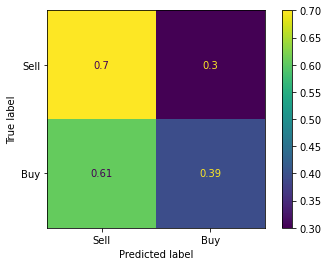

In [5]:
m.run_statistics(DatasetEnum.Validation)

509/509 [==============================] - 2s 4ms/step


{'log_val': 0.69634611142168,
 'accuracy_val': 0.5299827967559597,
 'f_1': 0.4614951428973673,
 'recall': 0.39666021297192644,
 'precision': 0.5516661056883204,
 'auc': 0.5320794824220592}

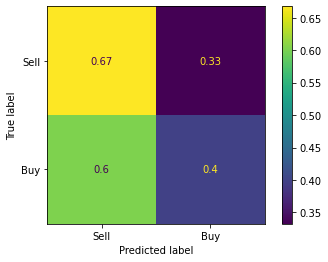

In [6]:
m.run_statistics(DatasetEnum.Test)

In [7]:
m.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 320)           423680    
                                                                 
 lstm_1 (LSTM)               (None, 10, 320)           820480    
                                                                 
 lstm_2 (LSTM)               (None, 32)                45184     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,290,433
Trainable params: 1,290,433
Non-

# ETH

In [8]:
from controllers.features import get_scaler
from sklearn.preprocessing import MinMaxScaler

eth_dataset = Data(
            lookback=10,
            train_size=0.6,
            validation_size=0.2,
            test_size=0.2,
            scaler=MinMaxScaler(),
            feature_set=f"ETH_Data",
            time_to_predict=1,
            features=None,
        )

--------------------- X_train ---------------------
Features: ['ATR_3', 'ATR_7', 'ATR_14', 'ATR_32', 'BB_UPPER_5', 'BB_LOWER_5', 'BB_MIDDLE_5', 'BB_UPPER_10', 'BB_LOWER_10', 'BB_MIDDLE_10', 'BB_UPPER_20', 'BB_LOWER_20', 'BB_MIDDLE_20', 'BLOCK_SIZE', 'HASH_RATE', 'DIFFICULTY', 'TRANSACTION_RATE', 'ACTIVE_ADDRESSES', 'NEW_ADDRESSES', 'ROC_3', 'ROC_6', 'ROC_12', 'ROC_24', 'RSI_3', 'RSI_7', 'RSI_14', 'RSI_32', 'WILLIAMS_3', 'WILLIAMS_7', 'WILLIAMS_14', 'WILLIAMS_32', 'MI_3', 'MI_9', 'MI_18', 'CCI_5', 'CCI_10', 'CCI_20', 'BASP_BUY_10', 'BASP_SELL_10', 'BASP_BUY_20', 'BASP_SELL_20', 'BASP_BUY_40', 'BASP_SELL_40', 'ER_5', 'ER_10', 'ER_15', 'ER_20', 'MACD_LOW', 'MACD_SIGNAL_LOW', 'MACD_MID', 'MACD_SIGNAL_MID', 'MACD_HIGH', 'MACD_SIGNAL_HIGH', 'ADX_3', 'ADX_7', 'ADX_14', 'ADX_21', 'STOCH_3', 'STOCH_7', 'STOCH_14', 'STOCH_21', 'STOCHRSI_3', 'STOCHRSI_7', 'STOCHRSI_14', 'STOCHRSI_21', 'BBWIDTH_5', 'BBWIDTH_10', 'BBWIDTH_20', 'PERCENT_B_5', 'PERCENT_B_10', 'PERCENT_B_20', 'TARGET']
start date: 201

In [9]:
autoencoder_model_class = load("/home/williamharris/Dev/CQF_final_project/models/testing/ETH_autoencoder_model/model.pickle")
encoder_model = autoencoder_model_class.model.get_layer("encoder")

eth_encoded_dataset = Dataset(X_train=encoder_model.predict(eth_dataset.X_train), y_train=eth_dataset.y_train, 
        X_validation=encoder_model.predict(eth_dataset.X_validation), y_validation=eth_dataset.y_validation, 
        X_test=encoder_model.predict(eth_dataset.X_test), y_test=eth_dataset.y_test, feature_names=eth_dataset.feature_names)

348/348 [==============================] - 1s 2ms/step


Epoch 1/100
64/64 [==============================] - 9s 41ms/step - loss: 0.6931 - auc_2: 0.5087 - binary_accuracy: 0.5098 - val_loss: 0.6949 - val_auc_2: 0.5025 - val_binary_accuracy: 0.4812
Epoch 2/100
64/64 [==============================] - 1s 21ms/step - loss: 0.6931 - auc_2: 0.5079 - binary_accuracy: 0.5050 - val_loss: 0.6946 - val_auc_2: 0.5019 - val_binary_accuracy: 0.4812
Epoch 3/100
64/64 [==============================] - 1s 21ms/step - loss: 0.6930 - auc_2: 0.5112 - binary_accuracy: 0.5100 - val_loss: 0.6951 - val_auc_2: 0.5079 - val_binary_accuracy: 0.4812
Epoch 4/100
64/64 [==============================] - 1s 19ms/step - loss: 0.6931 - auc_2: 0.5088 - binary_accuracy: 0.5081 - val_loss: 0.6950 - val_auc_2: 0.5010 - val_binary_accuracy: 0.4812
Epoch 5/100
64/64 [==============================] - 1s 19ms/step - loss: 0.6930 - auc_2: 0.5119 - binary_accuracy: 0.5096 - val_loss: 0.6946 - val_auc_2: 0.5075 - val_binary_accuracy: 0.4812
Epoch 6/100
64/64 [=====================

{'log_val': 0.6926414946722185,
 'accuracy_val': 0.5275654285457325,
 'f_1': 0.4464116345241858,
 'recall': 0.3776074166518096,
 'precision': 0.5458762886597938,
 'auc': 0.5289126012478649}

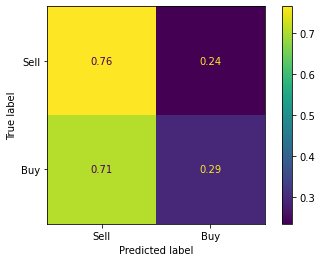

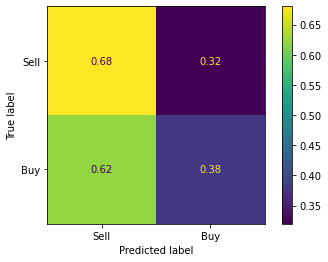

In [12]:
class Model(BaseModelFromScratch):
    def create_model(self):
        self.model = tf.keras.models.Sequential()
        self.model.add(
            tf.keras.layers.LSTM(
                128,
                dropout=0.3, 
                return_sequences=True,
                input_shape=(self.dataset.X_train.shape[1:]),
            )
        )
        self.model.add(tf.keras.layers.LSTM(128, dropout=0.3, return_sequences=True))
        self.model.add(tf.keras.layers.LSTM(64, dropout=0.3))
        self.model.add(tf.keras.layers.Dense(32, activation="relu"))
        self.model.add(tf.keras.layers.Dropout(0.1))
        self.model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    def train_model(self):
        opt = tf.keras.optimizers.Nadam(learning_rate=0.0005)
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard = tf.keras.callbacks.TensorBoard(f"{self.directory}/{self.project_name}/tb_logs/{time}")
        early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)
        self.model.compile(
            loss="binary_crossentropy",
            optimizer=opt,
            metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()],
        )
        class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(self.dataset.y_train.tolist()), y=[i for x in self.dataset.y_train for i in x])
        class_weights = dict(enumerate(class_weights))

        self.model.fit(
            self.dataset.X_train,
            self.dataset.y_train,
            validation_data=(self.dataset.X_validation, self.dataset.y_validation),
            epochs=100,
            batch_size=526,
            class_weight=class_weights,
            callbacks=[early_stop, tensorboard],
            shuffle=False,
        )

m = Model(model_name="eth_autoencoder", directory='models', project_name='testing', dataset=eth_encoded_dataset)
m.train()
m.run_statistics(DatasetEnum.Validation)
m.run_statistics(DatasetEnum.Test)

In [13]:
m.save_model()

INFO:tensorflow:Assets written to: ram://3838755b-75b3-4571-bd47-e78290bbf33d/assets


INFO:tensorflow:Assets written to: ram://3838755b-75b3-4571-bd47-e78290bbf33d/assets
